<a href="https://colab.research.google.com/github/reitezuz/18NES1-2026/blob/main/week02/example_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example:  Letters
#### Dataset Description:
The dataset consists of 78 black and white images of letters represented as numerical arrays.
Each image is a 50x50 grid where pixel values are either -1 (black) or 1 (white).
- The first column in the dataset contains the class label, which represents the letter index (1-26).
- The remaining columns contain pixel values for the respective image.

In [12]:
# load the perceptron_library.py file into google colab
import urllib.request

url = 'https://raw.githubusercontent.com/reitezuz/18NES1-2026/refs/heads/main/week02/perceptron_library.py'
filename = 'perceptron_library.py'
urllib.request.urlretrieve(url, filename)


('perceptron_library.py', <http.client.HTTPMessage at 0x792c3d316570>)

In [13]:
# import libraries
from perceptron_library import Perceptron, perceptron_error
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt


### Auxiliary functions


In [14]:
def load_letter_data():
    """ Load letter image data from a CSV file hosted on GitHub into numpy arrays """
    github_url = "https://github.com/reitezuz/18NES1-2026/blob/main/week02/letters.csv"
    url = github_url.replace("github.com", "raw.githubusercontent.com").replace("blob/", "")
    df = pd.read_csv(url, header=None)
    labels = df.iloc[:, 0].values   # First column is the class label
    inputs = df.iloc[:, 1:].values  # Remaining columns are features (-1, 1)
    return inputs, labels

def visualize_letter(X, labels, index):
    """ Visualize the i-th row of the data as a 50x50 black and white image """
    image = - X[index].reshape(50, 50)  # Reshape to 50x50
    letter = label_to_letter(labels[index])
    plt.figure(figsize=(2,2))         # Figure size
    plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.title(f"Letter Image at Index {index} ... {letter}")
    plt.axis('off')
    plt.show()

def label_to_letter(label):
    """ Convert a label (1-26) to a corresponding letter (A-Z) """
    return chr(label + 64)

def add_noise(X, alpha=0.01):
    """ Add salt & pepper noise to the dataset and apply median filtering """
    from scipy.ndimage import median_filter
    X = (X + 1) / 2  # Convert from [-1,1] to [0,1]
    X_noisy = X.copy()
    X_denoised = X.copy()

    for i in range(X.shape[0]):
        img = X[i].reshape(50, 50)

        # Add salt & pepper noise
        noisy_img = img.copy()
        noise = np.random.choice([0, 1, -1], size=img.shape, p=[1 - alpha, alpha / 2, alpha / 2])
        noisy_img[noise == -1] = 0  # Salt (white)
        noisy_img[noise == 1] = 1   # Pepper (black)

        # Apply median filter
        denoised_img = median_filter(noisy_img, size=3)

        # Flatten back to vector form
        X_noisy[i] = noisy_img.flatten()
        X_denoised[i] = denoised_img.flatten()

    X_noisy = X_noisy * 2 - 1  # Convert back to [-1,1]
    X_denoised = X_denoised * 2 - 1  # Convert back to [-1,1]

    return X_noisy, X_denoised

def show_noisy_and_denoised(X_original, X_noisy, X_denoised, index):
    """ Display original, noisy, and denoised images side by side """
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    original_img = - X_original[index].reshape(50, 50)
    noisy_img = - X_noisy[index].reshape(50, 50)
    denoised_img = - X_denoised[index].reshape(50, 50)

    axes[0].imshow(original_img, cmap='gray', vmin=-1, vmax=1)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(noisy_img, cmap='gray', vmin=-1, vmax=1)
    axes[1].set_title("Noisy Image")
    axes[1].axis('off')

    axes[2].imshow(denoised_img, cmap='gray', vmin=-1, vmax=1)
    axes[2].set_title("Denoised Image")
    axes[2].axis('off')

    plt.show()

def run_example_multiple_times_letters(experiment_results, inputs, test_inputs1, test_inputs2, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=100):
    times = []
    errors = []
    test_errors1 = []
    test_errors2 = []
    epoch_counts = []

    for _ in range(num_runs):
        perceptron = Perceptron(weights, bias, binary)
        start_time = time.time()
        if variant == 'rosenblatt best':
            perceptron.rosenblatt_iterative_best(inputs, true_outputs, learning_rate, epochs, False)  # Suppress individual run progress
        elif variant == 'rosenblatt iterative':
            perceptron.rosenblatt_iterative(inputs, true_outputs, learning_rate, epochs, False)
        elif variant == 'rosenblatt batch':
            perceptron.rosenblatt_batch(inputs, true_outputs, learning_rate, epochs, False)
        else:
            perceptron.hebbian(inputs, true_outputs, False)
        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = perceptron.forward(inputs)
        test_outputs1 = perceptron.forward(test_inputs1)
        test_outputs2 = perceptron.forward(test_inputs2)
        error = perceptron_error(true_outputs, real_outputs)
        test_error1 = perceptron_error(true_outputs, test_outputs1)
        test_error2 = perceptron_error(true_outputs, test_outputs2)

        times.append(elapsed_time)
        errors.append(error)
        test_errors1.append(test_error1)
        test_errors2.append(test_error2)
        epoch_counts.append(perceptron.epochs)

    avg_time = np.mean(times)
    avg_error = np.mean(errors)
    avg_test_error1 = np.mean(test_errors1)
    avg_test_error2 = np.mean(test_errors2)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'Error': avg_error,
        'Test Error 1': avg_test_error1,
        'Test Error 2': avg_test_error2,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': perceptron.weights, #Note: Weights and bias are from the last run.
        'Bias': perceptron.bias,
        'Data Description': data_description
    }
    experiment_results.loc[len(experiment_results)] = results
    return perceptron

### Analyze the data:

In [15]:
# Load the data:
[inputs, labels] = load_letter_data()

print(np.shape(inputs), np.shape(labels))
print(np.max(inputs), np.min(inputs), np.max(labels), np.min(labels))



(78, 2500) (78,)
1 -1 26 1


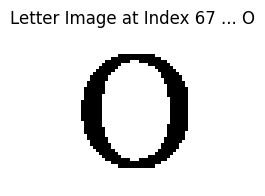

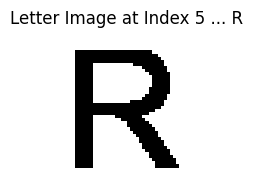

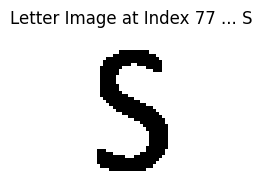

In [16]:
# Visualize some letters:
indexes = [67, 5, 77]
for index in indexes:
    visualize_letter(inputs, labels, index)


Create the testing set by adding noise and denoising:
- experiment with the level of noise, alpha

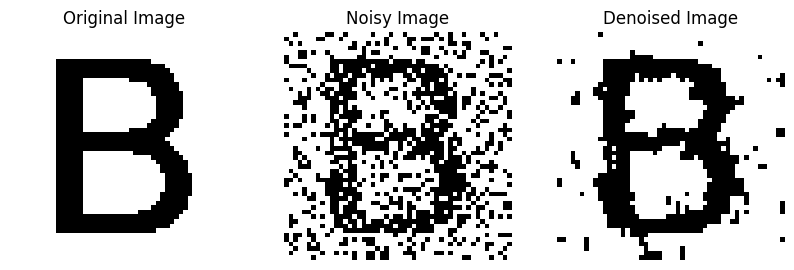

In [17]:
[inputs_noisy, inputs_denoised] = add_noise(inputs, alpha=0.5)
index = 10
show_noisy_and_denoised(inputs, inputs_noisy, inputs_denoised, index)

### Example: Train the Perceptron to recognize a letter

In [18]:
# DataFrame to store the results for comparisons
experiment_results_let = pd.DataFrame(columns=['Error', 'Test Error 1', 'Test Error 2', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results:

In [19]:
letter_index = 24 # 1...26
alpha = 0.5       # level of noise in the testing data

# Preprocess the data:
[inputs, labels] = load_letter_data()
[inputs_noisy, inputs_denoised] = add_noise(inputs, alpha=alpha)
true_outputs = np.where(labels == letter_index, 1, -1)
data_description = "Letter " + label_to_letter(letter_index) + f" {(sum(true_outputs == 1))}"

# Set Perceptron parameters:
weights = np.zeros(inputs.shape[1])
bias = 0
binary = False
epochs = 100
learning_rate = 1
print_progress = False
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
perceptron = run_example_multiple_times_letters(experiment_results_let, inputs, inputs_noisy, inputs_denoised, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=1)

print("\nExperiment Results:")
experiment_results_let


Experiment Results:


,Error,Test Error 1,Test Error 2,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.0,1.0,0.0,3.0,0.008571,rosenblatt iterative,1,100,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-1,Letter X 3


- visualize the misclassified letters:

Misclassified Letters:
Misclassified Letters:


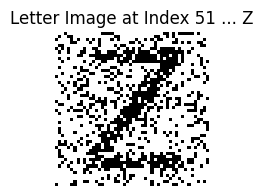

  Predicted: 1, Actual: -1
Misclassified Letters:


In [20]:
for inputs1 in [inputs, inputs_noisy, inputs_denoised]:
    outputs = perceptron.forward(inputs1)

    # Find misclassified letters
    misclassified_indices = []
    outputs = perceptron.forward(inputs1)
    for i in range(len(outputs)):
        if outputs[i] != true_outputs[i]:
            misclassified_indices.append(i)

    # Visualize misclassified letters
    print("Misclassified Letters:")
    for index in misclassified_indices:
        visualize_letter(inputs1, labels, index)
        print(f"  Predicted: {1 if outputs[index] > 0 else -1}, Actual: {true_outputs[index]}")

- visualize some correctly classified letters:

Correctly Classified Letters:


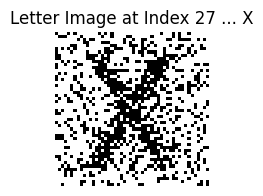

  Predicted: 1, Actual: 1


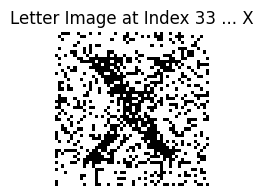

  Predicted: 1, Actual: 1


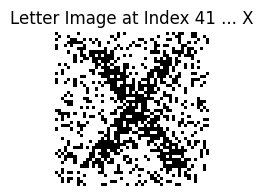

  Predicted: 1, Actual: 1
Correctly Classified Letters:


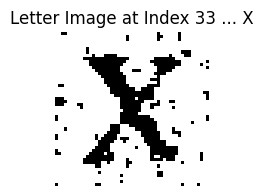

  Predicted: 1, Actual: 1


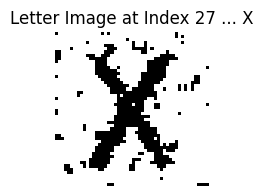

  Predicted: 1, Actual: 1


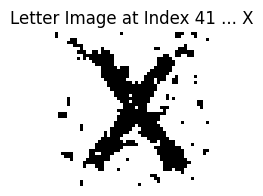

  Predicted: 1, Actual: 1


In [21]:
for inputs1 in [inputs_noisy, inputs_denoised]:
    outputs = perceptron.forward(inputs1)

    # Find correctly classified letters
    correctly_classified_indices = []
    outputs = perceptron.forward(inputs1)
    for i in range(len(outputs)):
        if outputs[i] == true_outputs[i] == 1:
            correctly_classified_indices.append(i)

    # Visualize the letters
    import random
    num_to_visualize = 5  # Adjust the number of images to visualize
    random_indices = random.sample(correctly_classified_indices, min(num_to_visualize, len(correctly_classified_indices)))
    print("Correctly Classified Letters:")
    for index in random_indices:
        visualize_letter(inputs1, labels, index)
        print(f"  Predicted: {1 if outputs[index] > 0 else -1}, Actual: {true_outputs[index]}")


- compare the results for the letters:

In [22]:
alpha = 0.5
# DataFrame to store the results for comparisons
experiment_results_l = pd.DataFrame(columns=['Error', 'Test Error 1', 'Test Error 2', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
for letter_index in range(1,27):
    [inputs, labels] = load_letter_data()
    [inputs_noisy, inputs_denoised] = add_noise(inputs, alpha=alpha)
    true_outputs = np.where(labels == letter_index, 1, -1)
    data_description = "Letter " + label_to_letter(letter_index) + " Num.:" + f" {(sum(true_outputs == 1))}"
    num_runs = 100

    # Set Perceptron parameters:
    weights = np.zeros(inputs.shape[1])
    bias = 0
    binary = False
    epochs = 100
    learning_rate = 1
    print_progress = False
    variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

    # run the experiment:
    run_example_multiple_times_letters(experiment_results_l, inputs, inputs_noisy, inputs_denoised, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=num_runs)

print("\nExperiment Results:")
experiment_results_l


Experiment Results:


,Error,Test Error 1,Test Error 2,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.0,0.07,0.16,2.94,0.008250,rosenblatt iterative,1,100,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-1,Letter A Num.: 3
1,0.0,0.67,1.18,3.73,0.010143,rosenblatt iterative,1,100,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-1,Letter B Num.: 3
2,0.0,1.07,1.29,5.44,0.015318,rosenblatt iterative,1,100,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",-2,Letter C Num.: 3
3,0.0,0.38,0.86,3.19,0.009248,rosenblatt iterative,1,100,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-1,Letter D Num.: 3
4,0.0,0.79,1.79,5.87,0.016357,rosenblatt iterative,1,100,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",-2,Letter E Num.: 3
5,0.0,0.93,0.96,5.34,0.023597,rosenblatt iterative,1,100,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...",-3,Letter F Num.: 3
6,0.0,0.43,0.46,3.99,0.011348,rosenblatt iterative,1,100,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-1,Letter G Num.: 3
7,0.0,0.31,0.49,3.71,0.010211,rosenblatt iterative,1,100,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",-2,Letter H Num.: 3
8,0.0,0.96,0.92,4.62,0.012870,rosenblatt iterative,1,100,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-1,Letter I Num.: 3
9,0.0,0.82,0.74,3.77,0.010688,rosenblatt iterative,1,100,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-1,Letter J Num.: 3
